# Regression Model to Predict Affinity from Protein Sequences using AlphaSeq Dataset

# *Exploratory Data Analysis (EDA)*
Andrew Kiruluta, 04/02/2023


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(5)

In [ ]:
# pick out relevant columns
fields = ["sequence_a","Kd","Kd_lower_bound","Kd_upper_bound"]
df= pd.read_csv('data/20230331_pembro_SSMplus_AlphaSeq_data.csv', usecols=fields)
df.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound
0,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.241963,1.191959,1.291968
1,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.379355,1.318349,1.440361
2,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.152859,1.120984,1.184735
3,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.123487,1.082745,1.164230
4,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.161713,1.128016,1.195410


In [608]:
# statistics of the target affinity value column
df.describe()

,Kd,Kd_lower_bound,Kd_upper_bound
count,29358.000000,30049.000000,29358.000000
mean,2.870087,2.512373,3.244432
std,0.802777,0.611098,1.018285
min,0.109426,0.088698,0.130155
25%,2.586133,2.372563,2.794151
50%,3.032297,2.666249,3.393826
75%,3.386192,2.888457,3.891682
max,4.912977,3.965893,5.934850


* We will keep the lower and upper bounds of affinities for comparison to inference spread within these limits.
* The affinity column which is our target has no infinities (we will check for nulls later) but the range between min/max is significant. We need to place the target on the same scale for the regression task - feature normalization.

In [609]:
# look for missing (NaN) values in the dataset
df.isnull().sum()

sequence_a          0
Kd                691
Kd_lower_bound      0
Kd_upper_bound    691
dtype: int64

691 protein sequences have NULL affinity (target) values. Without domain knowledge or background on the data, it makes sense to purge rows where Kd values are missing

In [610]:
df = df[df['Kd'].notna()]  # take only rows where Kd is not NaN, purge NaNs

# *Analyzing Protein Sequence Statistics:*
Protein sequence statistics visualizations are simple but very insightful: 

They include:

        sequence frequency analysis,
        sequence length analysis,
        average sequence length analysis,
        etc
These really help explore the fundamental characteristics of the protein sequence data.

To do so, we will be using histograms (continuous data) and bar charts (categorical data).

First, let us take a look at the distribution of protein sequence lengths in the dataset.

<AxesSubplot:>

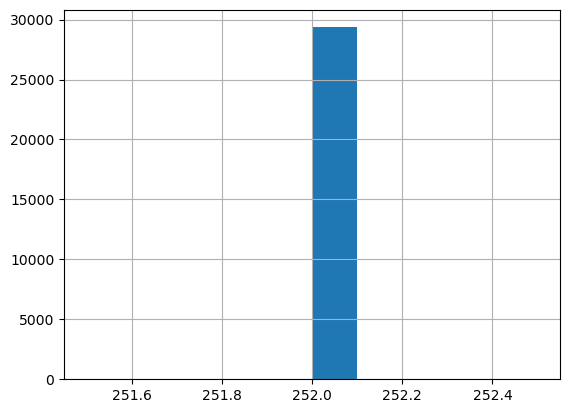

In [611]:
df['sequence_a'].str.len().hist()

In [612]:
# We see that all the protein sequences are of the same length, 252, no padding needed.
df['sequence_a'].str.len().describe()

count    29358.0
mean       252.0
std          0.0
min        252.0
25%        252.0
50%        252.0
75%        252.0
max        252.0
Name: sequence_a, dtype: float64

In [615]:
# look for number of unique protein sequences in the dataset
df['sequence_a'].nunique()

29199

In [616]:
print("number of repeated protein sequences in dataset: ", df.shape[0] - df['sequence_a'].nunique())

number of repeated protein sequences in dataset:  159


In [617]:
duplicate = df[df.duplicated('sequence_a')]
duplicate

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound
1,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.379355,1.318349,1.440361
2,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.152859,1.120984,1.184735
3,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.123487,1.082745,1.164230
4,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.161713,1.128016,1.195410
5,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.225249,1.183534,1.266964
...,...,...,...,...
29093,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.920335,2.664129,3.176542
29094,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.828503,2.450093,3.206913
29096,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.794269,2.499184,3.089354
29097,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,2.515867,2.321546,2.710188


In [618]:
# an example of a sequence that appears twice in the dataset but with different affinity values 
# in contradictory Kd upper and lower bounds limits
df['sequence_a'][0] == df['sequence_a'][1]

True

# Inconsistent Repeated Protein Sequences in the Data:
We see that there are 159 repeated protein sequences with inconsistent affinity values (Kd) and unfortunately, the upper and lower affinity bounds are also different for each respective repeated sequence pairs. I would forgive these inconsistences if the affinity values fell within consistent bounds but alas they do not! This makes it hard to trust using these rows in the model as they are not self consistent. We will therefore purge them from the training set.

In [619]:
df2 = df.drop_duplicates('sequence_a')
df2.shape
df2.to_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique.csv', index=False)

# *Now Let us look at the distribution of target affinity values (Kd):*

array([[<AxesSubplot:title={'center':'Kd'}>]], dtype=object)

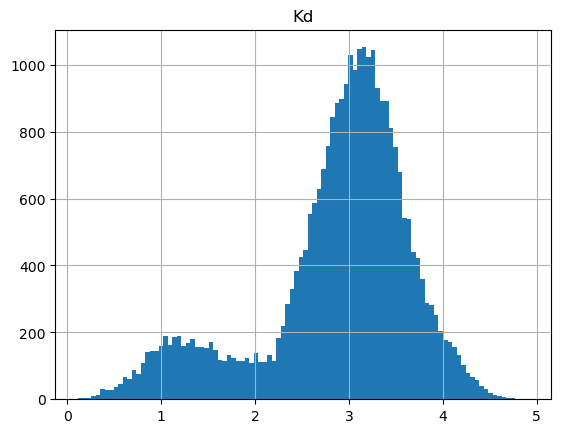

In [620]:
df.hist(column='Kd', bins=100)

The response variable (affinity Kd) displays a bimodal distribution, suggesting there are different populations in the data. This is a common issue with biological data arising from differences in species, sex, morphological, genetic, ecological, behavioural, etc.

It is true that regression does not make an assumption about the distribution of the dependent variable (it assumes Gaussianity about the residual errors). However, just because a model does not violate assumptions does not mean it is a good model. The usual regression models are models of the mean. Often, with a bimodal or multimodal response, the mean is not interesting. Often you would not use it as a measure of location -- in fact, there might not be a single good measure of location. So, if you aren't interested in the mean, why model it?

One way around this is quantile regression. Here we propose to regress on the quantiles that are peaks of your combined data.

# *Custom Tokenizer with Torch Embedding Layer:*
my M1 Pro chip (arm64) is not supported by the pretrained BertTokenizer module :( I will make a custom protein tokenizer here for converting each letter in the sequence to a unique integer for eventual embedding with torch.

In [533]:
MAX_PROT_LEN = 252
tok_emb = nn.Embedding(MAX_PROT_LEN, 1)

In [534]:
# AA_vocab and pos_vocab were used to train protein sequence activity oracle
AA_map = {'<PAD>': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4,
            'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
            'M': 11,'N': 12, 'P': 13, 'Q': 14, 'R': 15,
            'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

MAX_PROT_LEN = 252
VOCAB_SIZE = len(AA_map)
#tok_emb = nn.Embedding(VOCAB_SIZE, 1)

def get_protein_encoding(seq):
    encoding = [0]*MAX_PROT_LEN
    try:
        if len(seq) > MAX_PROT_LEN:
            seq = seq[:MAX_PROT_LEN]
        for i, aa in enumerate(seq):
            try:
                encoding[i] = AA_map[aa] 
            except Exception as e:
                encoding[i] = 0
    except Exception as e:
        pass
    return encoding

def embedding(seq):
    return tok_emb(torch.tensor(seq,dtype=torch.long)) 

def embedding2(seq):
    return tok_emb(torch.tensor(seq,dtype=torch.long)).detach().numpy() 


We also need to normalize the target affinity values to put them on the same scale

In [ ]:
# scale target Kd column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[['Kd']] = scaler.fit_transform(df2[['Kd']])

# *Save Processed DataFrame for Use in Regression Model Development Notebook:s*

In [537]:
df3 = df2.copy()
#df3['embedding'] = df3['sequence_a'].apply(lambda x: embedding2(get_protein_encoding(x)).flatten())
df3['embedding'] = df3['sequence_a'].apply(lambda x: get_protein_encoding(x))
df3.to_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique_embedding.csv', index=False)
df3.head(5)

,sequence_a,Kd,Kd_lower_bound,Kd_upper_bound,embedding
0,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,1.241963,1.191959,1.291968,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
50,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFNYYMYWVRQAPGQG...,3.751155,3.115660,4.386650,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
51,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFYYMYWVRQAPGQGL...,2.906238,2.620341,3.192135,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
52,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYWVRQAPGQGL...,3.230485,2.770773,3.690198,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
53,MASQVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQ...,3.045252,2.685666,3.404839,"[11, 1, 16, 14, 18, 14, 10, 18, 14, 16, 6, 18,..."
